<a href="https://colab.research.google.com/github/inrap8206/bigdata_analyst_certificate_korean/blob/main/%EB%B9%85%EB%B6%84%EA%B8%B0_%EC%8B%A4%EA%B8%B0_%EC%97%B0%EC%8A%B5%EB%AC%B8%EC%A0%9C%ED%92%80%EC%9D%B4_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 작업형2

## [빅분기예시] 작업형2

In [ ]:
import pandas as pd
import numpy as np 
y_train = pd.read_csv('https://raw.githubusercontent.com/Datamanim/dataq/main/y_train.csv')
X_train = pd.read_csv('https://raw.githubusercontent.com/Datamanim/dataq/main/X_train.csv', encoding='euc-kr')
test  = pd.read_csv('https://raw.githubusercontent.com/Datamanim/dataq/main/X_test.csv',encoding='euc-kr')
submission = test.iloc[:,:2]

train = pd.merge(X_train, y_train)

# 음수 데이터 삭제
train = train[train['총구매액']>0]

# 값이 1개인 범주형 데이터 삭제
train = train.loc[train['주구매지점'] != '상인점']

#이상값 처리
train.loc[train['총구매액']>250000000, '총구매액'] = 250000000

# # 데이터불균형 처리
# over_sample = train[train['gender'] == 1].sample(300, random_state=21) # +23% 오버샘플링
# train_1 = train[train['gender'] == 1]
# train_0 = train[train['gender'] == 0].sample(1900, random_state=20) # -13% 언더샘플링
# train = pd.concat([train_0, over_sample, train_1])
# print(train.gender.value_counts())

X_train = train.drop(['cust_id', 'gender'], axis=1)
y_train = train['gender']
test = test.drop(['cust_id'], axis=1)

data = pd.concat([X_train, test])

#환불금액 최소값이 0이,  아니므로 결측값을 0으로 변환
data['환불금액'].fillna(0, inplace=True)


# 범주형 데이터 처리
w_item = ['침구/수예', '디자이너', '액세서리', '시티웨어', '화장품', '농산물', '모피/피혁', '커리어']
m_item = ['식기', '주방가전', '남성 캐주얼', '주류', '남성정장', '악기']
data['주구매상품'] = data['주구매상품'].map(lambda x : '남성제품' if x in m_item else('여성제품' if x in w_item else x))

m_store = ['전주점', '안양점', '대구점', '울산점', '센텀시티점']
w_store = ['일산점', '부산본점', '강남점', '분당점', '잠실점', '본 점']
data['주구매지점'] = data['주구매지점'].map(lambda x : '남성매장' if x in m_store else('여성매장' if x in w_store else x))

# 파생변수 생성
data['최초구매액'] = data['총구매액'] + data['환불금액'] + 1
data['최대구매액비율'] = data['최대구매액']/data['최초구매액']
data['최대구매액비율2'] = data['총구매액']/data['최대구매액']
data['환불금액비율'] = data['환불금액']/data['최초구매액']
data['총구매건수'] = data['내점일수']*data['내점당구매건수']
data['내점기간'] = data['내점일수']*(data['구매주기']+1)
data['주말방문일수'] =data['내점일수']*data['주말방문비율']
data['평일방문일수'] = data['내점일수'] - data['주말방문일수']
data['주말만'] = data['주말방문비율'].map(lambda x : 1 if x == 1 else 0)
data['평일만'] = data['주말방문비율'].map(lambda x : 1 if x == 0 else 0)
data['주말>평일'] = data['주말방문비율'].map(lambda x : 1 if (x > 0.5) & (x !=1) else 0)
data['주말<평일'] = data['주말방문비율'].map(lambda x : 1 if (x < 0.5) & (x !=0) else 0)


# 원핫 인코딩
data = pd.get_dummies(data)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()
data= sc.fit_transform(data)

# 데이터 분할
X_train = data[:len(X_train)]
test = data[len(X_train):]

# 모델설계
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier(random_state=2021, n_estimators=400, max_depth=20, class_weight='balanced')

# 교차검증
scores = cross_val_score(model, X_train, y_train, 
                              cv=5,
                              scoring='roc_auc')
print("scores:\n", scores)
print("\nAverage score:")
print(scores.mean())

# model.fit(X_train, y_train)
# y_pred = model.predict_proba(test)
# submission = pd.DataFrame({'custid': submission.cust_id, 'gender' : y_pred[:,1]})
# submission.to_csv("수험번호.csv",index=False)

scores:
 [0.63137975 0.66258468 0.70403829 0.66989596 0.69030681]

Average score:
0.6716410969474366


### 주구매상품처리

In [ ]:
a = []
item_list = list(train['주구매상품'].unique())
for item in item_list:
  a.append(train[train['주구매상품'] == item]['gender'].mean())

tt = pd.DataFrame({'주구매상품':item_list, '주구매상품_':a})
tt = tt.sort_values(by='주구매상품_')
print(tt)

     주구매상품    주구매상품_
36   침구/수예  0.000000
4     디자이너  0.158163
20    액세서리  0.200000
5     시티웨어  0.220657
8      화장품  0.289855
7      농산물  0.298295
28   모피/피혁  0.327586
35     커리어  0.333333
3       보석  0.333333
34  란제리/내의  0.333333
22    일용잡화  0.358209
13      아동  0.365854
0       기타  0.405405
6       명품  0.419048
14    차/커피  0.431818
12     수산품  0.439024
15     캐주얼  0.444444
11    가공식품  0.454389
18    축산가공  0.472222
24    주방용품  0.485714
17      육류  0.500000
40    소형가전  0.500000
33   트래디셔널  0.500000
37    대형가전  0.500000
26      가구  0.500000
29  남성 트랜디  0.500000
21    피혁잡화  0.512195
19   젓갈/반찬  0.533333
1      스포츠  0.561644
32    생활잡화  0.562500
9       골프  0.568182
16    섬유잡화  0.571429
10      구두  0.573770
25    건강식품  0.584906
30      셔츠  0.666667
38  통신/컴퓨터  0.666667
39      식기  0.714286
23    주방가전  0.724138
2   남성 캐주얼  0.783333
27      주류  0.800000
31    남성정장  0.826087
41      악기  1.000000


In [ ]:
train['gender'] = train['gender'].replace(0,-1)
store_lst = list(train['주구매지점'].unique())
b = []
for store in store_lst:
  b.append(train[train['주구매지점'] == store]['gender'].sum())

ttt = pd.DataFrame({'주구매지점':store_lst, '내점일수_계':b})
ttt = ttt.sort_values(by='내점일수_계', ascending=False)
ttt



,주구매지점,내점일수_계
21,전주점,5
12,안양점,4
20,대구점,3
22,울산점,1
18,센텀시티점,0
19,인천점,-1
17,창원점,-2
15,포항점,-3
10,미아점,-4
2,관악점,-5


## [데이콘] 와인품질분류
- https://dacon.io/competitions/open/235610/overview/description

In [ ]:
train = pd.read_csv('./drive/My Drive/Colab Notebooks/빅분기 실기/연습_데이콘_와인품질분류/train.csv')
train['quality'].value_counts()

6    2416
5    1788
7     924
4     186
8     152
3      26
9       5
Name: quality, dtype: int64

In [ ]:
import pandas as pd
from google.colab import drive, files

drive.mount('/content/drive')

train = pd.read_csv('./drive/My Drive/Colab Notebooks/빅분기 실기/연습_데이콘_와인품질분류/train.csv')
test = pd.read_csv('./drive/My Drive/Colab Notebooks/빅분기 실기/연습_데이콘_와인품질분류/test.csv')
sub = pd.read_csv('./drive/My Drive/Colab Notebooks/빅분기 실기/연습_데이콘_와인품질분류/sample_submission.csv')

# 변주형 범수 처리
train['type'] = train['type'].map(lambda x : 1 if x == 'white' else 0)
test['type'] = test['type'].map(lambda x : 1 if x == 'white' else 0)

# 불필요 컬럼 삭제
label = train['quality']
train.drop(['index', 'quality'], axis=1, inplace=True)
test.drop('index', axis=1, inplace=True)

print('before : ', len(train))

# SMOTE
strategy = {3:40, 4:240, 5:1788, 6:2416, 7:924, 8:200, 9:8} 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=2022, k_neighbors=1, sampling_strategy=strategy) 
train, label = sm.fit_resample(train, label)
print('after : ', len(train))

# 피쳐 엔지니어링 (정제, 이상치처리, 파생변수 생성)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

train = sc.fit_transform(train)
test = sc.transform(test)



# 모델링
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


model = RandomForestClassifier(random_state=2022, n_estimators=394) #400

# 교차검증
score = cross_val_score(model, train, label, cv=5, scoring='accuracy')

print(score)
print(score.mean())


# 제출
model.fit(train, label)
preds = model.predict(test)
sub.iloc[:,1] = preds
sub.to_csv('wine.csv', index=False)
files.download('wine.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
before :  5497
after :  5616


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

[0.6886121  0.6794301  0.66429207 0.67764915 0.68299199]
0.6785950824399565


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.feature_importances_

array([0.07482554, 0.09986367, 0.0787481 , 0.08499937, 0.08797411,
       0.08579771, 0.09110996, 0.10078442, 0.08293066, 0.08660538,
       0.12279047, 0.00357061])

## [데이콘] 축구선수 이적료

In [ ]:
import pandas as pd
from google.colab import drive, files
drive.mount('/content/drive')

train = pd.read_csv('./drive/My Drive/Colab Notebooks/빅분기 실기/데이콘_축구이적료/train.csv')
test = pd.read_csv('./drive/My Drive/Colab Notebooks/빅분기 실기/데이콘_축구이적료/test.csv')
sub = pd.read_csv('./drive/My Drive/Colab Notebooks/빅분기 실기/데이콘_축구이적료/submission.csv')

label = train['value']
train.drop(['id', 'name', 'value'], axis=1, inplace=True)
test.drop(['id', 'name'], axis=1, inplace=True)

# train, test 병합

data = pd.concat([train, test])


# 범주형 처리
data['contract_until'] = pd.to_datetime(data['contract_until'])
data['contract_until_year'] = data['contract_until'].dt.year
data['contract_until_month'] = data['contract_until'].dt.month
data.drop('contract_until', axis=1, inplace=True)

data['cate'] = data['continent'] + '_' +	data['position']
data['cate'] = pd.get_dummies(data['cate'])

dic_conti = {'oceania' : 0, 'asia' : 1, 'europe' : 2, 'africa' : 3, 'south america' :4}
data['continent'] = data['continent'].map(dic_conti)

dic_pos = {'GK' : 0, 'DF' : 1, 'MF' : 2, 'ST' : 3}
data['position'] = data['position'].map(dic_pos)

data['prefer_foot'] = data['prefer_foot'].map(lambda x : 1 if x == 'left' else 0)

# 피쳐엔지니어링 (정제, 이상치, 파생변수)


# 데이터 분리
train = data[:len(train)]
test = data[len(train):]


# 스케일링
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train = sc.fit_transform(train)
test = sc.transform(test)

# 모델링
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

model = RandomForestRegressor(random_state=2020)

score = -1*cross_val_score(model, train, label, cv=5, scoring='neg_root_mean_squared_error')

print(score)
print('평균 : ',score.mean())
# 제출

model.fit(train, label)
preds = model.predict(test)
sub['value'] = preds
sub.to_csv('soccer.csv', index=False)
files.download('soccer.csv')

## [데이콘] 영화관객수 예측

In [ ]:
a=np.array([1,2,1,1,1])
a+10

array([11, 12, 11, 11, 11])

In [ ]:
ss = yf.Ticker("Shop")
ss

NameError: ignored

In [ ]:
import pandas as pd
from google.colab import drive, files
drive.mount('/content/drive')

train = pd.read_csv('./drive/My Drive/Colab Notebooks/빅분기 실기/데이콘_movie/train.csv')
test = pd.read_csv('./drive/My Drive/Colab Notebooks/빅분기 실기/데이콘_movie/test.csv')
sub = pd.read_csv('./drive/My Drive/Colab Notebooks/빅분기 실기/데이콘_movie/submission.csv')


label = train['box_off_num']
train.drop(['title', 'box_off_num'], axis=1, inplace=True)
test.drop(['title'], axis=1, inplace=True)

data = pd.concat([train, test])

# 결측값 처리
data = data.fillna(0)

# 범주형 처리
data['distributor_diretor'] = data['distributor'] + '_' +data['director']


for i in ['NEW', '쇼박스', 'CJ', 'CGV', 'SK', '싸이더스']:
   data['distributor'] = data['distributor'].map(lambda x : i if i in x else x)

genre_label = {'느와르':11, '액션':10, 'SF':9, '코미디':8, '드라마':7, '공포':6, '미스터리':5, '멜로/로맨스':4, '애니메이션':3, '서스펜스':2, '다큐멘터리':1, '뮤지컬':0}
data['genre'] = data['genre'].map(genre_label)

data = pd.get_dummies(data)



# 피쳐엔지니어링(정제, 이상치, 파생변수 등)

# 데이터 분리
train = data[:len(train)]
test = data[len(train):]


# 모델링
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
model = RandomForestRegressor(random_state=2020)

score = -1*cross_val_score(model, train, label, cv=5, scoring='neg_root_mean_squared_error')

print(score)
print('평균 : ',score.mean())
# 제출

model.fit(train, label)
preds = model.predict(test)
sub['box_off_num'] = preds
sub.to_csv('movie.csv', index=False)
files.download('movie.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[1218225.42348285 1225824.81372853 1094526.15754126 1934808.16711838
 1797653.21352594]
평균 :  1454207.5550793947


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train = pd.read_csv('./drive/My Drive/Colab Notebooks/빅분기 실기/데이콘_movie/train.csv')



,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,films
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,1
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.5,2,387,3,7072501,4
2,파괴된 사나이,시너지,공포,2010-07-01,114,청소년 관람불가,우민호,NaN,0,290,5,1012310,4
3,간첩,롯데엔터테인먼트,드라마,2012-09-20,115,15세 관람가,우민호,1012310.0,1,372,5,1310895,4
4,내부자들: 디 오리지널,(주)쇼박스,느와르,2015-12-31,180,청소년 관람불가,우민호,3131902.0,3,382,3,2084844,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,차이나타운,CGV아트하우스,느와르,2015-04-29,110,청소년 관람불가,한준희,597497.0,3,420,3,1472147,1
596,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.0,1,510,7,1475091,1
597,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.0,1,286,6,1716438,1
598,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475,1


## [데이콘] 타이타닉

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

# 오버샘플링
train1 = train[train['Survived'] == 1]
train2 = train[train['Survived'] == 1].sample(n=100, random_state=1)
train3 = train[train['Survived'] == 0].sample(n=442, random_state=1)
train = pd.concat([train3, train1, train2])


y_train = train['Survived']
X_train = train.drop('Survived', axis=1)
X_test = test.copy()
X_data = pd.concat([X_train, X_test])
X_data.drop(['Name', 'PassengerId'], axis=1, inplace=True)

# 결측값 ('Age','Cabin')
X_data['Age'].fillna(X_data['Age'].mean(), inplace=True)
X_data['Fare'].fillna(X_data['Fare'].mean(), inplace=True)
X_data['Cabin'].fillna('C23 C25 C27', inplace=True)
X_data['Embarked'].fillna('S', inplace=True)

# 범주형 ('Name'-삭제, 'Sex'-바이너리, 'Ticket'-원핫, 'Cabin'-원핫, 'Embarked'-Ordinal)
X_data['Sex'] = X_data['Sex'].map(lambda x : 1 if x == 'female' else 0)
em_dic = {'S': 1, 'Q': 2, 'C': 1}
X_data['Embarked'] = X_data['Embarked'].map(em_dic)

X_data = pd.get_dummies(X_data)
X_data

# 데이터분리
X_train = X_data[:len(X_train)]
X_test = X_data[len(X_train):]

# 피쳐 엔지니어링(이상치, 정제, 파생변수, 선택)
# 모델링
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

model1 = GradientBoostingClassifier(random_state=2021)
model2 = RandomForestClassifier(random_state=2021)

# # 교차검증
score = cross_val_score(model1, X_train, y_train, cv=3, scoring='roc_auc')
print(score)
print("평균 : ",score.mean())

# 제출
model1.fit(X_train, y_train)
preds1 = model1.predict_proba(X_test)

model2.fit(X_train, y_train)
preds2 = model2.predict_proba(X_test)

preds = (preds1*0.6 + preds2*0.4)/2

sub['Survived'] = preds[:,1]
sub.to_csv('submission.csv', index=False)
files.download('submission.csv')

[0.87288564 0.88918    0.91498912]
평균 :  0.8923515873224327


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train = pd.read_csv('train.csv')
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

## [데이콘] 신용카드

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')
import pandas as pd

train=pd.read_csv('./drive/My Drive/Colab Notebooks/dacon/신용카드/train.csv')
test=pd.read_csv('./drive/My Drive/Colab Notebooks/dacon/신용카드/test.csv')
submission=pd.read_csv('./drive/My Drive/Colab Notebooks/dacon/신용카드/sample_submission.csv')

# 데이터 불균형 처리
# 오버
train1 = train[train['credit'] == 1].sample(n=2000, random_state=1)
train0 = train[train['credit'] == 0].sample(n=1000, random_state=1)
train = pd.concat([train0, train1, train])


y_train = train['credit']
X_train = train.drop(['credit', 'index'], axis=1)
X_test = test.drop('index', axis=1)

data = pd.concat([X_train, X_test])

#결측치 처리 'occyp_type'
data.fillna('none', inplace=True)

#범주형 처리 'gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type'
data = pd.get_dummies(data)

#피쳐엔지니어링

X_train = data[:len(X_train)]
X_test = data[len(X_train):]

#모델링
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier(random_state=2021)

#검증
score = -1*cross_val_score(model, X_train, y_train, cv=5, scoring = 'neg_log_loss')
print(score)
print('평균 : ', score.mean())

#제출
model.fit(X_train, y_train)
preds = model.predict_proba(X_test)
submission.iloc[:,1:] = preds
submission.to_csv('submission.csv', index=False)
files.download('submission.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[0.40442459 0.86900013 0.90135419 0.98222861 0.95776891]
평균 :  0.8229552850134372


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')
import pandas as pd

train=pd.read_csv('./drive/My Drive/Colab Notebooks/dacon/신용카드/train.csv')
test=pd.read_csv('./drive/My Drive/Colab Notebooks/dacon/신용카드/test.csv')
submission=pd.read_csv('./drive/My Drive/Colab Notebooks/dacon/신용카드/sample_submission.csv')


train.credit.value_counts()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2.0    16968
1.0     6267
0.0     3222
Name: credit, dtype: int64

## [데이콘] 자전거 이용 예측

In [ ]:
import pandas as pd
from google.colab import drive, files
drive.mount('/content/drive')
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

train = pd.read_csv('./drive/My Drive/Colab Notebooks/빅분기 실기/데이콘_자전거/train.csv')
test = pd.read_csv('./drive/My Drive/Colab Notebooks/빅분기 실기/데이콘_자전거/test.csv')
sub = pd.read_csv('./drive/My Drive/Colab Notebooks/빅분기 실기/데이콘_자전거/submission.csv')

y_train = train['count']
X_train = train.drop('count', axis=1)
X_test = test.copy()

X_data = pd.concat([X_train, X_test])
X_data.drop('id', axis=1, inplace=True)

# 결측값 처리
# mis_cols = ['hour_bef_temperature', 'hour_bef_humidity', 'hour_bef_visibility']
# for col in mis_cols:
#   X_data[col] = X_data[col].fillna(X_data[col].mean())

X_data.fillna(0, inplace=True)

# 표준화  StandardScaler, MinMaxScaler, RobustScaler
sc = StandardScaler()
X_data = sc.fit_transform(X_data)

# 모델링

X_train = X_data[:len(X_train)]
X_test = X_data[len(X_train):]

model = RandomForestRegressor(random_state=2021, max_depth=20)
score = -1*cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(score)
print('평균 : ', score.mean())

model.fit(X_train, y_train)
pred = model.predict(X_test)
sub['count'] = pred
sub.to_csv('subm.csv', index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[37.90645405 41.57233637 37.10517534 38.67123209 36.25402958]
평균 :  38.30184548572371


In [ ]:
sub

,id,count
0,0,NaN
1,1,NaN
2,2,NaN
3,4,NaN
4,5,NaN
...,...,...
710,2148,NaN
711,2149,NaN
712,2165,NaN
713,2166,NaN


## [서울시 모기발생상황 지표 예측]

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

X_train =pd.read_csv('https://raw.githubusercontent.com/Datamanim/mosquito/main/train_x.csv',encoding='euc-kr')
y_train =pd.read_csv('https://raw.githubusercontent.com/Datamanim/mosquito/main/train_y.csv',encoding='euc-kr')
X_test =pd.read_csv('https://raw.githubusercontent.com/Datamanim/mosquito/main/test_x.csv',encoding='euc-kr')
sub    =pd.read_csv('https://raw.githubusercontent.com/Datamanim/mosquito/main/sub.csv')

train = pd.merge(X_train, y_train)
X_data = pd.concat([X_train, X_test])


X_data['date'] = pd.to_datetime(X_data['date'])
X_data['year'] = X_data['date'].dt.year
X_data['month'] = X_data['date'].dt.month
X_data['day'] = X_data['date'].dt.day
X_data['weekday'] = X_data['date'].dt.weekday
X_data.drop('date', axis=1, inplace=True)

# 파생변수 생성
season = {'12':1, '1':1, '2':1,'3':2,'4':2,'5':2,'6':3,'7':3,'8':3,'9':4,'10':4,'11':4}
X_data['season'] = X_data['month'].apply(lambda x : season[str(x)])
X_data['rain'] = X_data['강수량(mm)'].map(lambda x : 1 if x >= 0.5 else 0)
X_data['hot'] = X_data['최고기온(℃)'].map(lambda x : 1 if x >= 28 else 0)


#이상치 처리
for col in ['강수량(mm)',	'평균기온(℃)',	'최저기온(℃)',	'최고기온(℃)']:
  q3 = np.percentile(X_data[col], 75)
  q1 = np.percentile(X_data[col], 25)
  iqr = q3-q1
  max_num = iqr+q3
  min_num = iqr+q1
  X_data[col] = X_data[col].map(lambda x : max_num if x > max_num else (min_num if x < min_num else x ))


# 표준화
from sklearn.preprocessing import MinMaxScaler, StandardScaler
sc = StandardScaler()
X_data = sc.fit_transform(X_data)


# 데이터 분리, 학습 데이터 설정
X_train = X_data[:len(X_train)]
X_test = X_data[len(X_train):]
y_train = y_train.iloc[:,1]


model1 = XGBRegressor(random_state=2021, n_estimators=400, learning_rate=0.07) # GradientBoostingRegressor XGBRegressor RandomForestRegressor AdaBoostRegressor,
model2 = GradientBoostingRegressor(random_state=2022, n_estimators=400)
score = cross_val_score(model2, X_train, y_train, cv=5, scoring='r2')
print(score)
print('평균 : ', score.mean())

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
preds = (pred1+pred2)/2
sub['mosquito_ratio'] = preds
sub.to_csv('submission.csv',index=False)

[0.80546793 0.85399454 0.72843716 0.77342194 0.61088081]
평균 :  0.754440476253236
[04:47:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
def FinalMseScore():
    import pandas as pd
    y_true = pd.read_csv("https://raw.githubusercontent.com/Datamanim/mosquito/main/result.csv")
    sub = pd.read_csv('./submission.csv')
    pred = sub.iloc[:,-1].values
    from sklearn.metrics import r2_score
    mse = r2_score(pred,y_true['mosquito_ratio'])    
    print('submission mse score : ',mse)
    return mse

final_mse = FinalMseScore()

submission mse score :  0.889707268987581


In [ ]:
x = train['최고기온(℃)']
y = train['mosquito_ratio']
from scipy import stats
stats.describe(x)

DescribeResult(nobs=1040, minmax=(-10.7, 39.6), mean=18.954903846153844, variance=123.25262270489375, skewness=-0.39062194749793844, kurtosis=-1.0071297463111004)

In [ ]:
data1 = [4,6,17,16,8,9]        # 관측치
data2 = [10,10,10,10,10,10]    # 기대치
chis = stats.chisquare(data1, data2)
chis


Power_divergenceResult(statistic=14.200000000000001, pvalue=0.014387678176921308)

# 작업형1

## [크롤링] 네이버 영화 데이터

In [ ]:
!pip install bs4

In [ ]:
# 네이버 영화 평점 순위의 랭킹사이트의 데이터를 requests를 이용하여 가져오고 parsing 하여 soup 변수에 저장하라

url = 'https://movie.naver.com/movie/sdb/rank/rmovie.nhn?sel=cur&date=20210503'

import requests
from bs4 import BeautifulSoup as bs
data = requests.get(url)
soup = bs(data.text)

In [ ]:
# 메타정보에 관한 모든 파싱값을 meta 변수에 저장하라

meta = soup.find_all('meta')
meta


In [ ]:
# 랭킹테이블의 모든파싱데이터를 가져와서 lstRanking 변수에 저장하라 class=list_ranking

lstRanking = soup.find(class_="list_ranking")
lstRanking.find(class_='blind')

<caption class="blind">랭킹 테이블</caption>

In [ ]:
# lstRanking에서 모든 영화의 순위, 이름, 평점, 영화정보링크를 가져와서
# 데이터프레임을 만들고 movieTable 변수에 저장하라

import pandas as pd

title= [x.text.strip() for x in lstRanking.find_all('div',class_='tit5')]
point =[x.text for x in lstRanking.find_all('td',class_='point')]
rank = range(1,len(point)+1)
link = ['https://movie.naver.com' + x.a.get('href') for x in lstRanking.find_all('div',class_='tit5')]

movieTable = pd.DataFrame({'rank':rank,'title':title,'point':point,'link':link})

In [ ]:
# movieTable에 date 컬럼을 추가하여 2021-05-03 을 입력하라

movieTable['date'] = '2021-05-03'
movieTable.head()

,rank,title,point,link,date
0,1,레옹,9.37,https://movie.naver.com/movie/bi/mi/basic.nhn?...,2021-05-03
1,2,다시 태어나도 우리,9.35,https://movie.naver.com/movie/bi/mi/basic.nhn?...,2021-05-03
2,3,피아니스트,9.33,https://movie.naver.com/movie/bi/mi/basic.nhn?...,2021-05-03
3,4,"미안해요, 리키",9.32,https://movie.naver.com/movie/bi/mi/basic.nhn?...,2021-05-03
4,5,부활: 그 증거,9.31,https://movie.naver.com/movie/bi/mi/basic.nhn?...,2021-05-03


## [통계검정] 다이아몬드 데이터셋

In [ ]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/dataq/main/diamonds.csv',index_col=0)

In [ ]:
# carat과 price사이의 상관계수와 상관계수의 p-value값은?
from scipy import stats
stats.pearsonr(df['carat'], df['price'])

(0.9215913011934771, 0.0)

In [ ]:
# Diamond의 평균가격은 3932로 알려져있다. ‘H’ color를 가지는 다이아몬드 집단의 평균에 대한 일표본 t검정을 시행하려한다.
# 통계량과 pvalue값을 구하시오.유의수준 0.05에서 귀무가설 채택여부를 boolean 값으로 표현할 변수(hypo) 만들고 출력하시오
from scipy import stats
stats.ttest_1samp(df[df['color'] == 'H']['price'], 3932)[1]
hypo = stats.ttest_1samp(df[df['color'] == 'H']['price'], 3932)[1] >= 0.05
print(hypo)

False


In [ ]:
# 그래프상에서 ‘F’와 ‘G’는 평균이 유사해보인다
# 이를 확인하기 위해 집단간 등분산(levene,fligner,bartlett) 검정을 시행 후 결과를 출력하고조건에 맞는 독립표본 t검정을 시행하라

x1 = df[df['color'] == 'F']['price']
x2 = df[df['color'] == 'G']['price']

print(stats.levene(x1,x2)[1]>0.05)
print(stats.fligner(x1,x2)[1]>0.05)
print(stats.bartlett(x1,x2)[1]>0.05)

print(stats.ttest_ind(x1,x2, equal_var = False)[1]>0.05)

False
False
False
False


In [ ]:
# color ‘F’,’G’,’D’ 세집단의 price값들에 대해 anova분석을 시행하라.

x1 = df[df['color'] == 'F']['price']
x2 = df[df['color'] == 'G']['price']
x3 = df[df['color'] == 'D']['price']

# 등분산 검정
print(stats.levene(x1,x2,x3)[1]>0.05)
print(stats.fligner(x1,x2,x3)[1]>0.05)
print(stats.bartlett(x1,x2,x3)[1]>0.05)
print()

# 정규성 검정
print(stats.kstest(x1, 'norm', args=(x1.mean(), x1.var()**0.5)))
print(stats.kstest(x2, 'norm'))
print(stats.kstest(x3, 'norm'))

# anova
print(stats.f_oneway(x1,x2,x3))

False
False
False

KstestResult(statistic=0.18798901810560872, pvalue=2.520563863700653e-293)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
F_onewayResult(statistic=101.1811790316069, pvalue=1.6513790091285713e-44)


In [ ]:
# 연속형 변수(carat,depth,table,price,x,y,z) 각각의 이상치(1,3분위값에서 IQR*1.5 외의 값) 갯수를
# 데이터 프레임(변수명 ratio_df, 비율의 내림차순 정렬)으로 아래와 같이 나타내어라.

cols = ['carat','depth','table','price','x','y','z']
values = []
for col in cols:
  iqr = np.percentile(df[col], 75) - np.percentile(df[col], 25)
  value = len(df[df[col] > (iqr*1.5 + np.percentile(df[col], 75))]) + len(df[df[col] < (np.percentile(df[col], 25) - iqr*1.5)])
  values.append(value)

pd.DataFrame({'column':cols,	'ratio':values}).sort_values(by='ratio', ascending=False)


,column,ratio
3,price,3540
1,depth,2545
0,carat,1889
2,table,605
6,z,49
4,x,32
5,y,29


In [ ]:
# color에 따른 price의 max, min, 평균값을 colorDf 변수에 저장하고 아래와 같이 출력하는 코드를 작성하라

df.groupby(['color'])['price'].agg(['max', 'min', 'mean'])

,max,min,mean
color,,,
D,18693,357,3169.954096
E,18731,326,3076.752475
F,18791,342,3724.886397
G,18818,354,3999.135671
H,18803,337,4486.669196
I,18823,334,5091.874954
J,18710,335,5323.818020


In [ ]:
# 전체 데이터중 color의 발생빈도수에 따라 labelEncoding (빈도수 적은것 : 1, 빈도수 증가할수록 1씩증가)을 하고
# colorLabel 컬럼에 저장하고 cut에 따른 colorLabel의 평균값을 구하여라

df['color'].value_counts()
label_dic = {'G':7, 'E':6, 'F':5, 'H':4, 'D':3, 'I':2, 'J':1}
df['colorLabel'] = df['color'].map(label_dic)
pd.DataFrame(df.groupby(['cut'])['colorLabel'].mean())

,colorLabel
cut,
Fair,4.516770
Good,4.562780
Ideal,4.769152
Premium,4.644913
Very Good,4.654362


In [ ]:
# price의 값에 따른 구간을 1000단위로 나누고 priceLabel 컬럼에 저장하라.
# 저장시 숫자 순으로 label하고(0~1000이하 : 0,1000초과~2000미만 :1 …)
# 최종적으로 구간별 갯수(변수명:labelCount)를 출력하라

df['priceLabel'] = df['price']//1000
pd.DataFrame(df['priceLabel'].value_counts())

,priceLabel
0,14499
1,9704
2,6131
4,4653
3,4226
5,3174
6,2278
7,1669
8,1307
9,1076


## [판다스] 게임판매량 데이터셋

In [ ]:
# 데이터 Url을 이용하여 df변수에 데이터를 로드하라
dataUrl = 'https://raw.githubusercontent.com/Datamanim/video/master/video_games_sale.csv'

df = pd.read_csv(dataUrl)

,Unnamed: 0,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Year_of_ten
0,0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E,2000.0
1,1,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,2000.0
2,2,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E,2000.0
3,3,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E,2000.0
4,4,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6820,6820,E.T. The Extra-Terrestrial,GBA,2001.0,Action,NewKidCo,0.01,0.00,0.00,0.00,0.01,46.0,4.0,2.4,21.0,Fluid Studios,E,2000.0
6821,6821,Mortal Kombat: Deadly Alliance,GBA,2002.0,Fighting,Midway Games,0.01,0.00,0.00,0.00,0.01,81.0,12.0,8.8,9.0,Criterion Games,M,2000.0
6822,6822,Metal Gear Solid V: Ground Zeroes,PC,2014.0,Action,Konami Digital Entertainment,0.00,0.01,0.00,0.00,0.01,80.0,20.0,7.6,412.0,Kojima Productions,M,2010.0
6823,6823,Breach,PC,2011.0,Shooter,Destineer,0.01,0.00,0.00,0.00,0.01,61.0,12.0,5.8,43.0,Atomic Games,T,2010.0


In [ ]:
# video_games_sales 데이터셋(video_games_sales.csv)의 출시년도(Year_of_Release) 컬럼을
# 10년단위(ex 1990~1999 : 1990)로 변환하여 새로운 컬럼(year_of_ten)에 추가하고
# 게임이 가장 많이 출시된 년도(10년단위)와 가장 적게 출시된 년도(10년단위)를 각각 구하여라.

df['year_of_ten'] = df['Year_of_Release']//10*10
print(df['year_of_ten'].value_counts().index[0])
print(df['year_of_ten'].value_counts().index[-1])


2000.0
1980.0


In [ ]:
# 플레이스테이션 플랫폼 시리즈(PS,PS2,PS3,PS4,PSV)중 장르가 Action로 발매된 게임의 총 수는?
len(df[(df['Platform'].isin(['PS','PS2','PS3','PS4','PSV'])) & (df['Genre'] == 'Action')])

616

In [ ]:
# 게임이 400개 이상 출시된 플랫폼들을 추출하여 각 플랫폼의 User_Score 평균값을 구하여
# 데이터프레임을 만들고 값을 내림차순으로 정리하여 출력하라

a = pd.DataFrame(df[df['Platform'].isin(list(df['Platform'].value_counts().index[:7]))].groupby(['Platform'])['User_Score'].mean())
a.sort_values(by='User_Score', ascending=False)

,User_Score
Platform,
PS2,7.664386
XB,7.540708
PC,7.060369
DS,7.047198
Wii,6.903758
PS3,6.782705
X360,6.780769


In [ ]:
# 게임 이름에 Mario가 들어가는 게임을 3회 개발한 개발자(Developer컬럼)을 구하여라

t = df[df['Name'].str.contains('Mario')]['Developer'].value_counts()
list(t[t==3].index)

['Nintendo, Nintendo Software Technology', 'Nintendo, Nd Cube']

In [ ]:
# PS2 플랫폼으로 출시된 게임들의 User_Score의 첨도를 구하여라
df[df['Platform'] == 'PS2']['User_Score'].kurtosis()

2.4920035946875965

In [ ]:
# 각 게임별 NA_Sales,EU_Sales,JP_Sales,Other_Sales 값의 합은 Global_Sales와 동일해야한다.
# 소숫점 2자리 이하의 생략으로 둘의 값의 다른경우가 존재하는데, 이러한 케이스가 몇개 있는지 확인하라

len(df[df['Global_Sales'] != df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']])

3636

In [ ]:
# User_Count컬럼의 값이 120 이상인 게임들 중에서 User_Score의 값이 9.0이상인 게임의 수를 구하여라
len(df[(df['User_Count'] >=120) & (df['User_Score'] >= 9)])

86

In [ ]:
# Global_Sales컬럼의 값들을 robust스케일을 진행하고 40이상인 데이터 수를 구하여라
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()

df['RS_Global_Sales'] = rs.fit_transform(df['Global_Sales'].values.reshape(-1,1))
len(df[df['RS_Global_Sales'] >= 40])

6

## [통계검정] mtcars
 - https://blog.naver.com/ostin1038/222381788634

In [ ]:
import pandas as pd
from google.colab import drive, files
drive.mount('/content/drive')

df = pd.read_csv('./drive/My Drive/Colab Notebooks/빅분기 실기/mtcars.csv')
df.head(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1


In [ ]:
# 문제1) 연비 mpg 변수 관련하여 단일표본 T검정 수행하고자 한다. 먼저 데이터가 정규성을 충족하는지
# 확인하기 위해 shapiro 테스트를 진행 하고 이를 통해 나오는  p-value 값을 소수 셋째자리까지 구하시오(넷째자리에서 버림)
from scipy.stats import shapiro

float(str(shapiro(df['mpg'])[1])[:5])

0.122

In [ ]:
# 문제2) 자동차 구매시 연비를 우선순위로 삼고자 한다. Mazda Rx4를 구매하고자 하는데 
#이 차량의 연비는 21.0이다. 이 연비 수준이 차량들의 평균 연비와 비슷한 수준인지 단일표본 T검정을 실시한다.
#21에 대한 단일표본 p-value값을 소수 셋째자리까지 구하시오.(넷째자리에서 버림)

from scipy.stats import ttest_1samp
float(str(ttest_1samp(df['mpg'], 21)[1])[:5])

0.399

In [ ]:
# 문제3) 오토 방식과 수동 방식간의 연비 차이가 통계적으로 유의미한지 확인하고자 한다.
# 오토방식은 am 변수의 1인 값이며 수동은 am 변수의 0이라 할 수 있다.
# 두집단의 평균 차이를 독립표본 T검정을 수행하기 앞서 두 집단의 아웃라이어를 IQR 방식을 활용하여 제거한 후 수행한다
# (3분위 + IQR*1.5 / 1분위 - IQR*1.5) 이때의 T-value 값의 절대값을 소수 셋째자리를 버림해 둘째자리 까지 구하시오
#(오토 방식은 13개 차량, 수동은 19개 차량이며 등분산은 우선 충족한다고 가정한다)

a = df[df['am'] == 1]['mpg']
m = df[df['am'] == 0]['mpg']

for i in [a,m]:
  iqr = np.percentile(i,75) - np.percentile(i,25)
  max_lim = iqr*1.5 + np.percentile(a,75)
  min_lim = np.percentile(a,25) - iqr*1.5
  i = i.loc[(i<max_lim) & (i>min_lim)]

from scipy.stats import ttest_ind
str(ttest_ind(a,m)[0])[:4]

'4.10'

In [ ]:
# 문제4) 다음 실린더 개수별 연비차이가 통계적으로 유의미한지를 ANOVA 분석을 통해 확인한다.
# cyl 변수 실린더 개수를 바탕으로 3가지 집단의 연비 값에 대해 ANOVA 분석을 수행하고
# F값을 소수 셋째자리에서 버림하여 둘째자리까지 나타내시오(정규성, 등분산은 우선 충족한다고 가정한다)

c1 = df[df['cyl'] == 4]['mpg']
c2 = df[df['cyl'] == 6]['mpg']
c3 = df[df['cyl'] == 8]['mpg']

from scipy.stats import f_oneway
str(f_oneway(c1,c2,c3)[0])[:5]

'39.69'

In [ ]:
# 문제5) 실린더의 개수가 차량의 가속도 능력과 연관성이 있는지를 카이스퀘어 검정을 통해 확인하고자 한다.
# 실린더 개수는 cyl변수를 활용하고 가속도 능력은 ¼ 마일에 도달하는 시간 변수인 qsec을 활용하여
# qsec의 하위 25%인 16.9 이하면 하 , 상위 25%인 18.9 이상이면 상 나머지는 중으로 명목척도화 한다.
# 이후 실린더 개수와 차량 가속도 능력에 대한 카이스퀘어 검정을 통해 연관성을 확인한다.
# p-value를 소수 둘째자리까지 구하시오(셋째자리에서 버림)

df['qsec_'] = df['qsec'].map(lambda x : 1 if x <= 16.9 else (3 if x >=18.9 else 1))
from scipy.stats import *
chisquare(df['qsec_'], df['cyl'])

Power_divergenceResult(statistic=119.66666666666667, pvalue=2.3614996254314185e-12)

## [군집분석] 백화점 DB
 - https://blog.naver.com/ostin1038/222383120717

In [ ]:
import pandas as pd
from google.colab import drive, files
drive.mount('/content/drive')

y_train = pd.read_csv('https://raw.githubusercontent.com/Datamanim/dataq/main/y_train.csv')
X_train = pd.read_csv('https://raw.githubusercontent.com/Datamanim/dataq/main/X_train.csv', encoding='euc-kr')

df = pd.concat([X_train, y_train], axis=1)
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,cust_id,gender
0,0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17,0,0
1,1,2136000,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1,1,0
2,2,3197000,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1,2,1
3,3,16077620,4935000,NaN,기타,광주점,18,2.444444,0.318182,16,3,1
4,4,29050000,24000000,NaN,보석,본 점,2,1.500000,0.000000,85,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,3042900,NaN,골프,본 점,1,2.000000,1.000000,0,3495,1
3496,3496,29628600,7200000,6049600.0,시티웨어,부산본점,8,1.625000,0.461538,40,3496,1
3497,3497,75000,75000,NaN,주방용품,창원점,1,1.000000,0.000000,0,3497,0
3498,3498,1875000,1000000,NaN,화장품,본 점,2,1.000000,0.000000,39,3498,0


문제1:  고객의 주 구매지점을 서울 지점과 비서울 지점을 집단으로 구분해 서울 지점과 비 지점간의 고객의 '평균 구매금액'을 대조해 보고자 한다. 
이를 위해 주구매지점 중 하단의 8개 지점은 서울 지점, 나머지 지점은 비서울 지점으로 구분하는 변수를 추가한다(서울=1, 비서울=0) 

서울 8개 지점: 본 점, 잠실점, 강남점, 노원점, 청량리점, 미아점, 관악점, 영등포점 

평균구매금액 공식은 다음과 같으며 비서울 지점 대비 

서울지점 집단평균구매금액 평균비를 소수 둘째자리까지 구하시오(셋째자리 버림) 

'평균구매금액' = '총구매액' / '내점일수'

In [ ]:
stores = ['본 점', '잠실점', '강남점', '노원점', '청량리점', '미아점', '관악점', '영등포점']
df['서울'] = 0
df.loc[df['주구매지점'].isin(stores), '서울'] = 1
df['평균구매금액'] = df['총구매액']/df['내점일수']

s = df[df['서울'] == 1]
n = df[df['서울'] == 0]

s['평균구매금액'].mean()/n['평균구매금액'].mean()


0.8663055743726116

문제2: 문제1에서 추가한 합성변수 '평균구매금액'와 '총구매액', '최대구매액', '환불금액', '내점일수', '주말방문비율', '구매주기' 7가지 변수를 바탕으로 새로운 데이터셋을 만들고 결측치가 있는 DB는 0으로 채운다. 

다음 StandardScaler 방식으로 표준화를 진행한다. 

표준화를 진행한 '평균구매금액'과 '총구매액' 변수 둘다 양의 정수의 조건을 충족하는 레코드개수의 수를 구하시오

In [ ]:
df1 = df[[ '평균구매금액','총구매액', '최대구매액', '환불금액', '내점일수', '주말방문비율', '구매주기' ]]
df1.fillna(0, inplace=True)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df2 = sc.fit_transform(df1)
ans = pd.DataFrame(df2, columns=df1.columns)

len(ans[(ans['평균구매금액']>0) & (ans['총구매액']>0)])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


623

문제3: 문제2에서 진행한 표준화 데이터셋 변수 7가지를 바탕으로 주성분분석(PCA)를 진행한다.(sklearn decomposition PCA 라이브러리 활용)

이때 세번째 주성분까지의 누적 분산 비율을 구하시오
(소수 셋째자리 버림 둘째자리까지 구하시오)


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pcafit = pca.fit_transform(ans)
df3 = pd.DataFrame( pcafit, columns = ['com1', 'com2', 'com3', 'com4', 'com5'] )
a = pca.explained_variance_ratio_
a[0] + a[1] + a[2]

0.7098680077486345

문제4: 문제3에서 진행했던 주성분분석 첫번째 주성분과 두번째 주성분의 아래 공식을 대입한 값을 소수 둘째자리까지 구하시오(셋째자리 버림) 
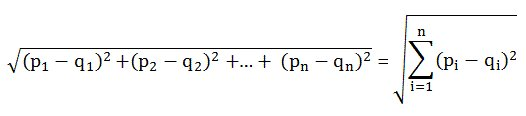



In [ ]:
def dist(x,y):
  return np.sqrt(np.sum((x - y) ** 2))

print(dist(df3['com1'], df3['com2']))

117.91246772995495


문제5: 문제3에서 진행했던 주성분분석 첫번째부터 네번째 주성분 데이터셋을 바탕으로 군집분석을 수행한다. 방법은 계층적 군집분석이고 계산법은 유클리드 거리, 와드연결법으로 수행한다. 군집을 3개로 나눈다고 할때 레코드 수가 가장 많은 군집의 레코드수를 구하여라 

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters = 3, affinity='euclidean', linkage='ward')
df5 = df3.drop('com5', axis=1)
df5['group'] = cluster.fit_predict(df5)
print( df5['group'].value_counts())



0    2794
2     355
1     351
Name: group, dtype: int64


In [ ]:
from sklearn.metrics import pairwise

dir(pairwise)

In [ ]:
표준화 후

